# Data Preprocessing

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.metrics import Recall, Precision

In [2]:
#Check GPU device available
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Load dataset
data_train = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
data_test = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

In [5]:
# Handle missing value and duplicate if any
data_train.dropna(inplace=True)
data_train.drop_duplicates(inplace=True)

data_test.dropna(inplace=True)
data_test.drop_duplicates(inplace=True)

In [6]:
#Split Attack and Normal from dataframe
data_train_attack = data_train[data_train['label'] == 1]
data_test_attack = data_test[data_test['label'] == 1]

#Optional
#data_train_normal = data_train[data_train['label'] == 0]
#data_test_normal = data_test[data_test['label'] == 0]

In [7]:
# Drop id and label from train and test data
data_train_attack = data_train_attack.drop('id', axis=1)
data_train_attack = data_train_attack.drop('label', axis=1)

data_test_attack = data_test_attack.drop('id', axis=1)
data_test_attack = data_test_attack.drop('label', axis=1)

In [8]:
print(data_train_attack['state'].nunique())
print(data_test_attack['state'].nunique())

6
5


In [9]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'ACC' 'CON' 'REQ' 'CLO']
['INT' 'FIN' 'CON' 'REQ' 'RST']


In [10]:
#Drop ACC, CLO, and RST from data
data_train_attack = data_train_attack[(data_train_attack['state'] != 'ACC') & (data_train_attack['state'] != 'CLO')]
data_test_attack = data_test_attack[(data_test_attack['state'] != 'RST')]

In [11]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'CON' 'REQ']
['INT' 'FIN' 'CON' 'REQ']


## Encode Train and Test Data

In [12]:
#column to encode
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [13]:
#One-hot Encoding
# Encode train data
data_train_attack = pd.get_dummies(data_train_attack, columns=cols)

# Encode test data
data_test_attack = pd.get_dummies(data_test_attack, columns=cols)

In [14]:
train_attack_cat = data_train_attack.pop('attack_cat')
test_attack_cat = data_test_attack.pop('attack_cat')

## Normalization

In [15]:
# Min-Max Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_to_norm = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 
                'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 
                'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 
                'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 
                'ct_srv_dst', 'is_sm_ips_ports']

data_train_attack[cols_to_norm] = scaler.fit_transform(data_train_attack[cols_to_norm])
data_test_attack[cols_to_norm] = scaler.fit_transform(data_test_attack[cols_to_norm])

## Feature Selection

In [16]:
#Feature Selection
feature = data_train_attack.drop(['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'], axis=1)
feature.dtypes

dur               float64
spkts             float64
dpkts             float64
sbytes            float64
dbytes            float64
                   ...   
service_radius       bool
service_smtp         bool
service_snmp         bool
service_ssh          bool
service_ssl          bool
Length: 181, dtype: object

# Split Data

In [17]:
#Splitting the dataset into dependent and independent feature
X_train = feature
y_train = train_attack_cat

X_test = data_test_attack.drop(columns=['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'])
y_test = test_attack_cat

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45329, 181), (45329,), (119329, 181), (119329,))

# Model Architecture

## CNN Model

In [18]:
# Define the input shape
input_shape = (181, 1)

#Create the sequential model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2)) # reduces the spatial dimensions of the output volume
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D()) # computes the average of all values across the spatial dimensions, effectively flattening the data
model.add(Dropout(0.5)) # helps prevent overfitting by randomly setting a fraction of input units to 0 during training
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [19]:
#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 179, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 89, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 87, 128)           24704     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               3

## Train the model

In [20]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [22]:
num_class = 9
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [23]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [24]:
#Define epochs and batch size
epochs = 10
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
1417/1417 [==============================] - 23s 14ms/step - loss: 1.0791 - accuracy: 0.6125 - recall: 0.4327 - precision: 0.8594 - val_loss: 0.9432 - val_accuracy: 0.6706 - val_recall: 0.4672 - val_precision: 0.8929
Epoch 2/10
1417/1417 [==============================] - 21s 15ms/step - loss: 0.8625 - accuracy: 0.6828 - recall: 0.5490 - precision: 0.8818 - val_loss: 0.9039 - val_accuracy: 0.6702 - val_recall: 0.4802 - val_precision: 0.8888
Epoch 3/10
1417/1417 [==============================] - 22s 15ms/step - loss: 0.8304 - accuracy: 0.6894 - recall: 0.5620 - precision: 0.8891 - val_loss: 0.8928 - val_accuracy: 0.6777 - val_recall: 0.4799 - val_precision: 0.8882
Epoch 4/10
1417/1417 [==============================] - 22s 15ms/step - loss: 0.8111 - accuracy: 0.6948 - recall: 0.5673 - precision: 0.8956 - val_loss: 0.8712 - val_accuracy: 0.6864 - val_recall: 0.4935 - val_precision: 0.9251
Epoch 5/10
1417/1417 [==============================] - 22s 16ms/step - loss: 0.7882 - a

In [25]:
#Define epochs and batch size
epochs = 20
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/20
1417/1417 [==============================] - 23s 16ms/step - loss: 0.6989 - accuracy: 0.7412 - recall: 0.6273 - precision: 0.8958 - val_loss: 0.8438 - val_accuracy: 0.6967 - val_recall: 0.5714 - val_precision: 0.8652
Epoch 2/20
1417/1417 [==============================] - 23s 16ms/step - loss: 0.6907 - accuracy: 0.7443 - recall: 0.6324 - precision: 0.8973 - val_loss: 0.8082 - val_accuracy: 0.7006 - val_recall: 0.5821 - val_precision: 0.8801
Epoch 3/20
1417/1417 [==============================] - 23s 16ms/step - loss: 0.6847 - accuracy: 0.7486 - recall: 0.6396 - precision: 0.8956 - val_loss: 0.8100 - val_accuracy: 0.7054 - val_recall: 0.5749 - val_precision: 0.8830
Epoch 4/20
1417/1417 [==============================] - 24s 17ms/step - loss: 0.6781 - accuracy: 0.7514 - recall: 0.6442 - precision: 0.8937 - val_loss: 0.8075 - val_accuracy: 0.6861 - val_recall: 0.5882 - val_precision: 0.8649
Epoch 5/20
1417/1417 [==============================] - 23s 16ms/step - loss: 0.6719 - a

In [26]:
#Define epochs and batch size
epochs = 30
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/30
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5980 - accuracy: 0.7735 - recall: 0.6866 - precision: 0.8903 - val_loss: 0.7650 - val_accuracy: 0.7240 - val_recall: 0.6086 - val_precision: 0.8732
Epoch 2/30
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5938 - accuracy: 0.7731 - recall: 0.6845 - precision: 0.8941 - val_loss: 0.7469 - val_accuracy: 0.7324 - val_recall: 0.6072 - val_precision: 0.8866
Epoch 3/30
1417/1417 [==============================] - 22s 15ms/step - loss: 0.5904 - accuracy: 0.7747 - recall: 0.6880 - precision: 0.8957 - val_loss: 0.7403 - val_accuracy: 0.7503 - val_recall: 0.6191 - val_precision: 0.8840
Epoch 4/30
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5879 - accuracy: 0.7743 - recall: 0.6869 - precision: 0.8957 - val_loss: 0.7399 - val_accuracy: 0.7329 - val_recall: 0.6129 - val_precision: 0.8902
Epoch 5/30
1417/1417 [==============================] - 20s 14ms/step - loss: 0.5861 - a

In [27]:
#Define epochs and batch size
epochs = 40
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/40
1417/1417 [==============================] - 22s 16ms/step - loss: 0.5472 - accuracy: 0.7844 - recall: 0.7004 - precision: 0.9021 - val_loss: 0.7610 - val_accuracy: 0.7087 - val_recall: 0.6014 - val_precision: 0.8677
Epoch 2/40
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5471 - accuracy: 0.7857 - recall: 0.6994 - precision: 0.9042 - val_loss: 0.7311 - val_accuracy: 0.7405 - val_recall: 0.6263 - val_precision: 0.8867
Epoch 3/40
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5473 - accuracy: 0.7848 - recall: 0.6994 - precision: 0.9047 - val_loss: 0.7191 - val_accuracy: 0.7349 - val_recall: 0.6271 - val_precision: 0.8895
Epoch 4/40
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5446 - accuracy: 0.7860 - recall: 0.7005 - precision: 0.9035 - val_loss: 0.7357 - val_accuracy: 0.7469 - val_recall: 0.6122 - val_precision: 0.8767
Epoch 5/40
1417/1417 [==============================] - 20s 14ms/step - loss: 0.5446 - a

In [28]:
#Define epochs and batch size
epochs = 50
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
1417/1417 [==============================] - 22s 15ms/step - loss: 0.5184 - accuracy: 0.7929 - recall: 0.7106 - precision: 0.9076 - val_loss: 0.7358 - val_accuracy: 0.7285 - val_recall: 0.6184 - val_precision: 0.8847
Epoch 2/50
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5161 - accuracy: 0.7943 - recall: 0.7112 - precision: 0.9106 - val_loss: 0.7492 - val_accuracy: 0.7218 - val_recall: 0.6087 - val_precision: 0.8907
Epoch 3/50
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5186 - accuracy: 0.7928 - recall: 0.7084 - precision: 0.9100 - val_loss: 0.7250 - val_accuracy: 0.7334 - val_recall: 0.6213 - val_precision: 0.8893
Epoch 4/50
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5155 - accuracy: 0.7947 - recall: 0.7123 - precision: 0.9094 - val_loss: 0.7264 - val_accuracy: 0.7401 - val_recall: 0.6385 - val_precision: 0.8858
Epoch 5/50
1417/1417 [==============================] - 21s 15ms/step - loss: 0.5146 - a

## Evaluate The Model

In [29]:
#Evaluate the model on test data
loss, accuracy, recall, precision = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Recall:', recall)
print('Test Precision:', precision)

3730/3730 [==============================] - 19s 5ms/step - loss: 0.7574 - accuracy: 0.7173 - recall: 0.6161 - precision: 0.8593
Test Loss: 0.7573957443237305
Test Accuracy: 0.7173025608062744
Test Recall: 0.6160698533058167
Test Precision: 0.8593320846557617


In [30]:
# make a predictions
predictions = model.predict(X_test)

3730/3730 [==============================] - 6s 2ms/step


In [31]:
# convert one-hot encode predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

### Confusion Matrix

In [32]:
# function to calculate recall from confusion matrix
def calculate_recall(confusion_matrix):
    num_class = len(confusion_matrix)
    recalls = []

    for i in range(num_class):
        true_positive = confusion_matrix[i][i]
        false_negative = sum(confusion_matrix[i]) - true_positive

        recall = true_positive / (true_positive + false_negative)
        recalls.append(recall)
    
    return recalls

In [33]:
# function to display the recall score
def display_recall(recalls):
    print('Recall Scores for each class:')
    print('Analysis:', recalls[0])
    print('Backdoor:', recalls[1])
    print('DoS:', recalls[2])
    print('Exploits:', recalls[3])
    print('Fuzzers:', recalls[4])
    print('Generic:', recalls[5])
    print('Reconnaissance:', recalls[6])
    print('Shellcode:', recalls[7])
    print('Worms:', recalls[8])

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
matrix = confusion_matrix(y_test_categorical, predicted_classes)
matrix_df = pd.DataFrame(matrix, 
                         index= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'], 
                         columns= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'])

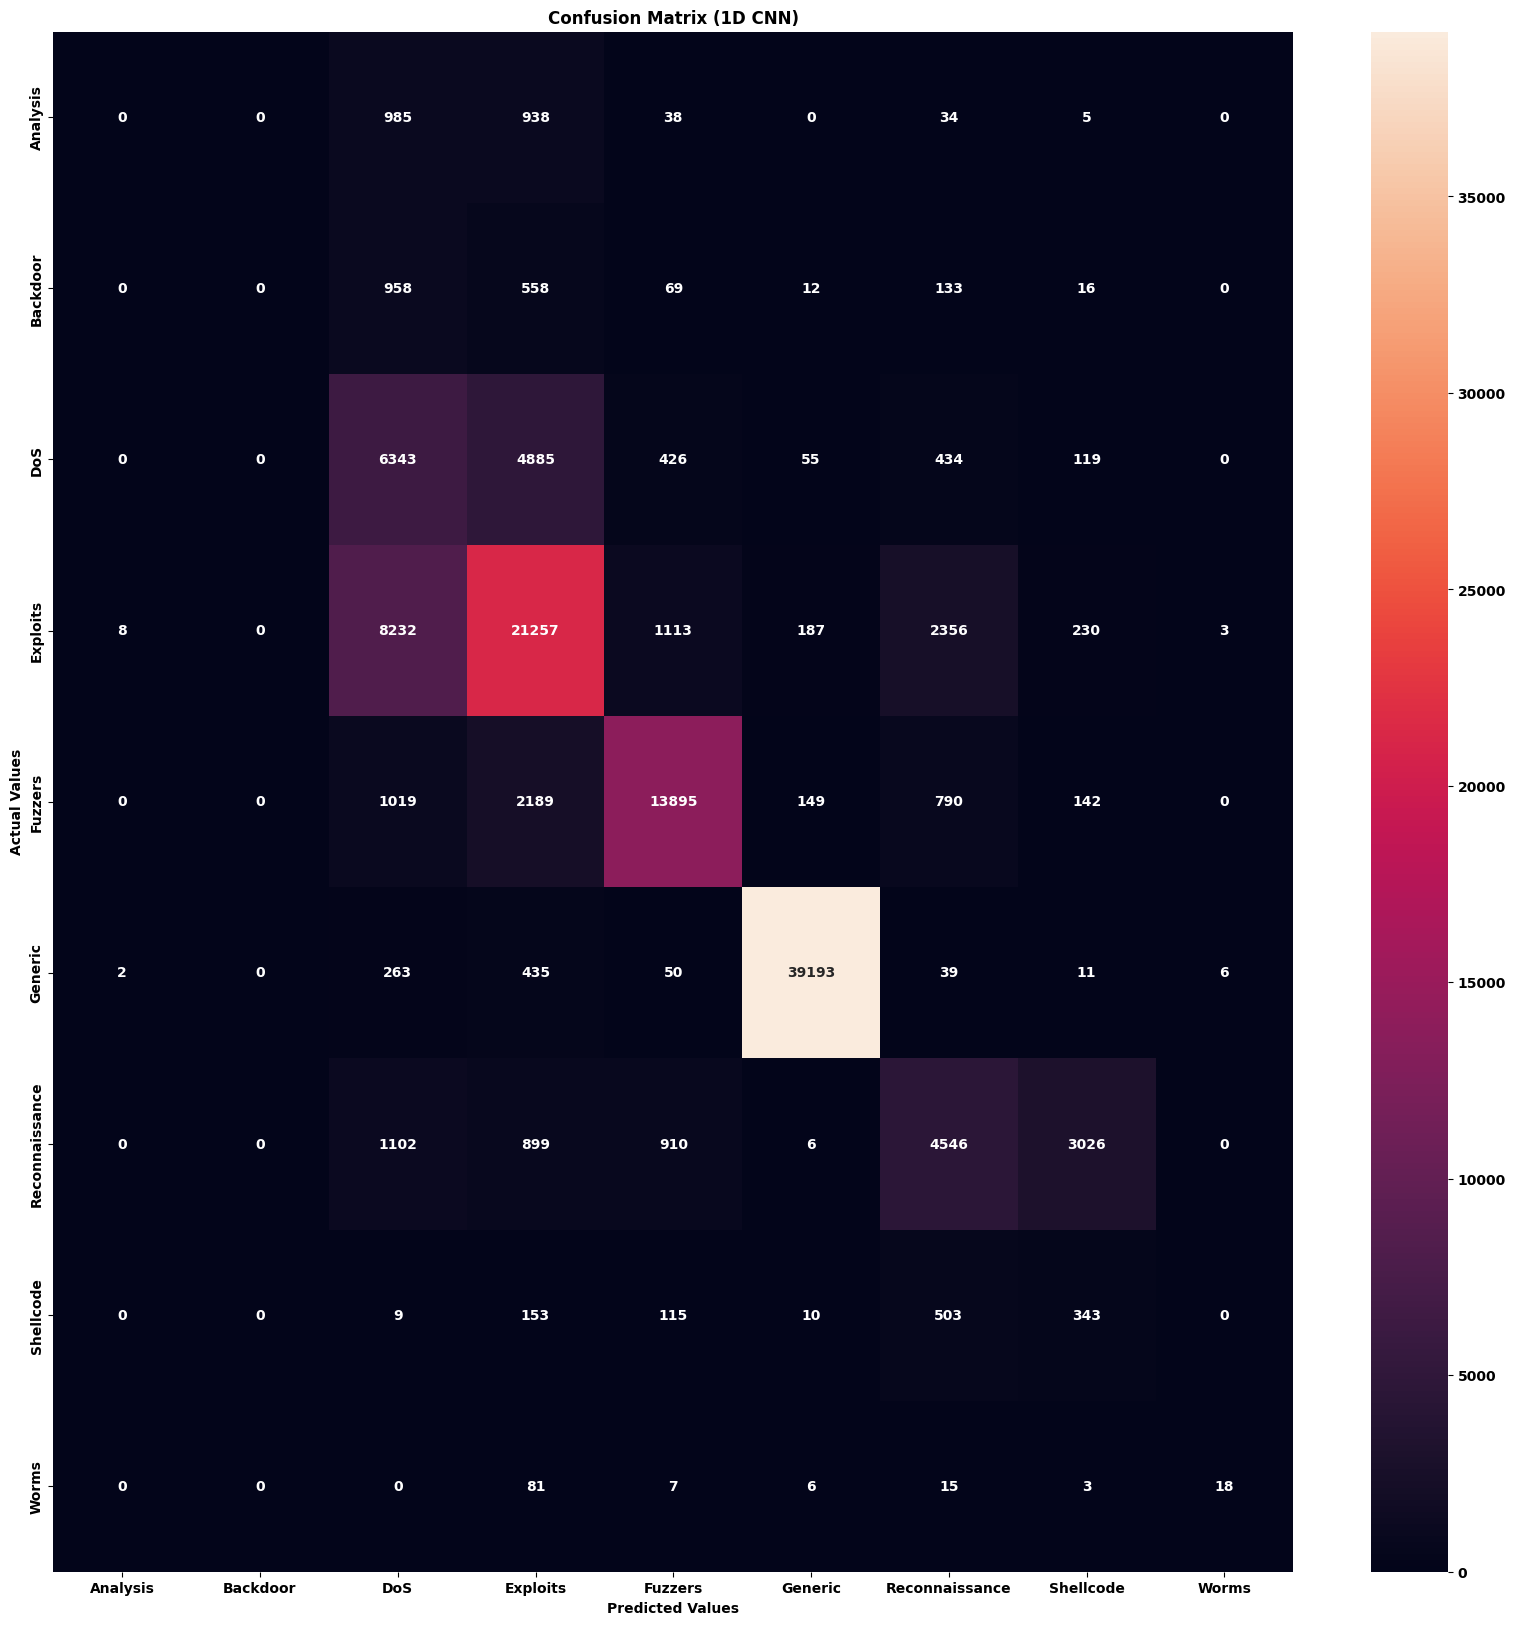

In [36]:
# Plotting Confusion Matrix
plt.figure(figsize = (20, 20))
sns.heatmap(matrix_df, fmt='.0f', annot=True)
plt.title('Confusion Matrix (1D CNN)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [37]:
recalls = calculate_recall(matrix)
display_recall(recalls)

Recall Scores for each class:
Analysis: 0.0
Backdoor: 0.0
DoS: 0.5172891861034089
Exploits: 0.6367040076678847
Fuzzers: 0.7641333040035195
Generic: 0.9798494962374059
Reconnaissance: 0.4334064257793879
Shellcode: 0.3027360988526037
Worms: 0.13846153846153847


## Save and load the model

In [38]:
from keras.models import load_model

In [39]:
# save the 1D CNN trained model using keras
model.save('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/cnn1d.keras')

In [40]:
# load the 1D CNN trained model using keras
model = load_model('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/cnn1d.keras')

## Save and load the predicted

In [41]:
import pickle

In [42]:
# save the decision tree trained model
with open('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/predicted_classes.pkl', 'wb') as model_file:
    pickle.dump(predicted_classes, model_file)

In [43]:
# load the decision tree trained model
with open('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/predicted_classes.pkl', 'rb') as model_file:
    predicted_classes = pickle.load(model_file)